# Exploratory Data Analysis

## Analysis on the data provided on home sales

### Section 1: Fetching and processing of data from database

#### 1.1 Fetching data and simple manipulation

We first have to access the database by establishing a connection using sqlite3 and making use of the <em>read_sql_query</em> method provided by the pandas package to load the table from the .db file to a Dataframe object as shown below.

In [8]:
import sqlite3
import pandas

con = sqlite3.connect("data/home_sales.db")

full_df = pandas.read_sql_query("SELECT * FROM SALES", con)
full_df['condition'] = full_df['condition'].str.lower()
full_df.replace(to_replace='terrible', value='1.0', inplace=True) # convert categorical data to numerical data
full_df.replace(to_replace='poor', value='2.0', inplace=True)
full_df.replace(to_replace='fair', value='3.0', inplace=True)
full_df.replace(to_replace='good', value='4.0', inplace=True)
full_df.replace(to_replace='excellent', value='5.0', inplace=True)
full_df = full_df.astype({'condition': 'float64'})

# simple reordering to have target column as the last column
cols = list(full_df.columns.values)
#print(cols)
cols.remove('price')
cols.append('price')
reordered_df = full_df[cols]
reordered_df = reordered_df.drop(columns=['id','date'])
print(reordered_df.columns)

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'review_score', 'basement_size', 'built', 'renovation', 'zipcode',
       'latitude', 'longitude', 'living_room_size', 'lot_size', 'price'],
      dtype='object')


Reordering has been done to have the <em>price</em> column as the last column instead of the third so as to facilitate visualizations for later sections. The <em>date</em> and <em>id</em> column has been dropped as date of sale is not a factor that affects price of housing and the transaction id is produced after the house has been sold, thus a nonfactor to price of housing.

#### 1.2 Handling of Missing data / Null values

In [9]:
cleaned_df = reordered_df.dropna()
num_rows_lost = len(reordered_df) - len(cleaned_df)
percentage_loss = (num_rows_lost / len(reordered_df)) * 100
print("Total number of rows before removing missing values = {}".format(len(reordered_df)))
print("Total number of rows after removing missing values = {}".format(len(cleaned_df)))
print("Number of rows removed = {}".format(num_rows_lost))
print("Percentage of rows lost = {:4.2f}%".format(percentage_loss))

Total number of rows before removing missing values = 23154
Total number of rows after removing missing values = 19688
Number of rows removed = 3466
Percentage of rows lost = 14.97%


Going through the dataframe, it is clear there are missing / NaN values in the data, so with some simple calculations, it is found that the number of rows containing one or more missing values is 3466 out of 23154 rows, approximately 15% of the entire database. 

Simply deleting all rows with missing values results in loss of information and data. Firstly, the target column is the <em>price</em> column. Having missing values in the <em>price</em> column is not good and imputing values to the target column may breed inaccuracy. Hence, rows with missing values in the <em>price</em> column shall be discarded.

In [10]:
valid_price_df = reordered_df[reordered_df['price'].notna()]
print("Number of rows with missing price values = {}".format(len(reordered_df) - len(valid_price_df)))
percentage_rows = (1 - (len(valid_price_df) / len(reordered_df))) * 100
print("Percentage of rows removed = {:3.2f}%".format(percentage_rows))

Number of rows with missing price values = 1258
Percentage of rows removed = 5.43%


With that, it comes to 1258 rows with missing <em>price</em> values and 5.43% loss in data.



#### 1.3 Imputation of data

The missing values in the features columns should not be discarded and can be infered through imputation

In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=20, weights='distance')

x = valid_price_df.drop(columns=['price'])
y = valid_price_df['price']
imputer.fit(x, y)
x_trans = imputer.transform(x)
column_names = ['bedrooms', 'bathrooms','floors', 'waterfront', 'view', 
                'condition', 'review_score', 'basement_size', 'built', 
                'renovation', 'zipcode', 'latitude', 'longtitude', 'living_room_size', 'lot_size']

trans_df = pandas.DataFrame.from_records(x_trans, columns=column_names)

The price of housing is similar for houses of similar design, number of rooms(both bedrooms and bathrooms) available, space, and geological area. Hence, with that in mind, a KNNImputer will be excellent for imputing values as it compares data from neighbors. The weight function of the imputer is set to <b>distance</b> as a house with similar features should have similar pricing.

### Section 2: Visualizations on data

#### 2.1 Pairwise correlation between all features

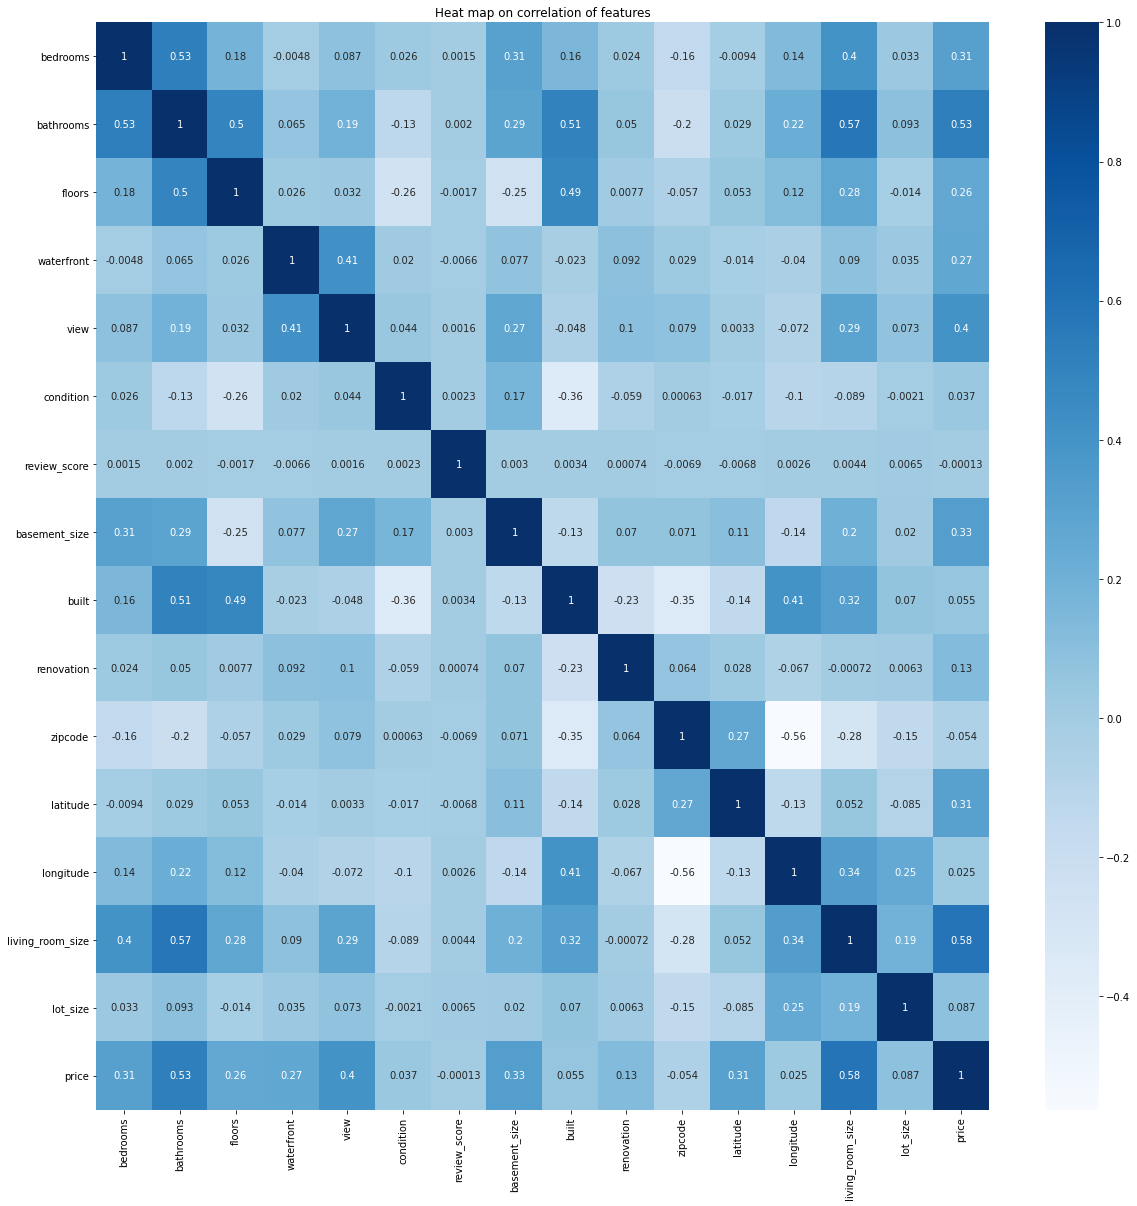

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = reordered_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.title("Heat map on correlation of features")
plt.show()

The dataframe.corr() method provides insight on the pairwise correlation between any 2 columns of the dataframe, with exclusion of the NA / Null values. The imputed values are not used here as they may impact the correlation value.

Making use of the pearson correlation coefficient, the above heat map on the pairwise correlation between any 2 columns of the dataframe is obtained. The main focus here is how the <em>price</em> column is related to each of the features, which is represented by the last row in the heatmap. As seen from above, the <em>living_room_size</em> and <em>bathrooms</em> features are the 2 features that are moderately positively correlated to <em>price</em>, with values of 0.58 and 0.53 respectively. 

Several features hae little to no impact on the price of housing such as <em>condition</em> and <em>review-score</em> of the house, when it is <em>built</em>, <em>zipcode</em>, <em>longitude</em> and the <em>lot_size</em>, all with values of less than 0.1.

This heat map also serves as a reference to the importance of each feature on affecting the price of housing.

### Section 3: Feature Selection using sklearn

- We can make use of the feature selection library in sklearn to find out and hence eliminate features that have little impact on the price.
- 3 different methods are employed to figure out the importance of each feature for comparison

#### 3.1: Filtering of features using VarianceThreshold method


In [13]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold= 0.8 * (1 - 0.8))
vt.fit(trans_df)
print(list(trans_df.columns))
print(vt.get_support(indices=True))

['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'review_score', 'basement_size', 'built', 'renovation', 'zipcode', 'latitude', 'longtitude', 'living_room_size', 'lot_size']
[ 0  1  2  4  5  6  7  8  9 10 13 14]


Upon running the <b>VarianceThreshold</b> method provided by the <b>sklearn.feature_selection</b> library, we can see the waterfront, latitude and longitude features was not selected. However, this is expected as for the aforementioned features, their values do not vary much. The data is based on sales in a county within USA, therefore the change in latitude and longitude of the houses sold is little. The waterfront column is indictaion of whether the house has a waterfront view, 0 for no, 1 for yes, and since there are only 2 values, the variance for this column is little.

#### 3.2 Recursive Feature Elimination

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

model_LR = LinearRegression()
lr_rfe = RFECV(model_LR)

lr_rfe.fit(trans_df,y)

temp = pandas.Series(lr_rfe.support_,index = trans_df.columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

model_DTR = DecisionTreeRegressor()
dtr_rfe = RFECV(model_DTR)

dtr_rfe.fit(trans_df,y)

temp = pandas.Series(dtr_rfe.support_,index = trans_df.columns)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'review_score', 'basement_size', 'built', 'renovation', 'zipcode',
       'latitude', 'longtitude', 'living_room_size', 'lot_size'],
      dtype='object')
Index(['bedrooms', 'bathrooms', 'waterfront', 'view', 'basement_size', 'built',
       'zipcode', 'latitude', 'longtitude', 'living_room_size', 'lot_size'],
      dtype='object')


As seen from above, the RFECV unfortunately did not find an optimal number of features for the data provided using the <b>Linear Regression</b> model, but managed to do so with the <b>Decision Tree Regressor</b> model.
The <em>floors</em>, <em>condition</em>, <em>review_score</em> and <em>renovation</em> features are not selected and the optimal number of features as determined by the RFECV is 11.

#### 3.3 Making use of the models

##### 3.3.1 L1-based feature selection using LassoCV

Best alpha using built-in LassoCV: 856398.679634
Best score using built-in LassoCV: 0.397897


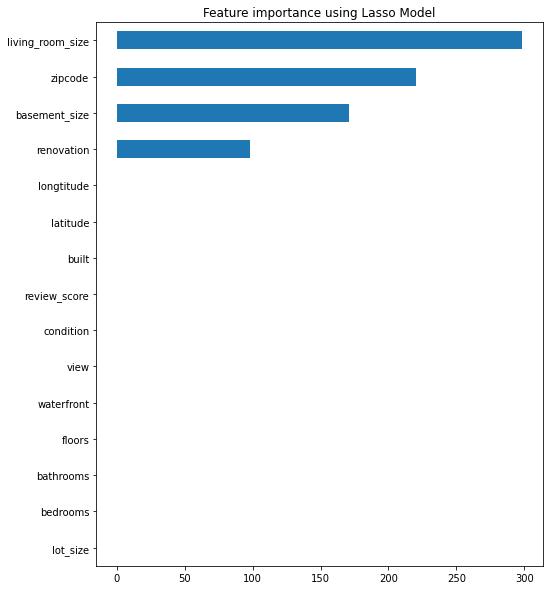

In [15]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(trans_df, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(trans_df,y))
coef = pandas.Series(reg.coef_, index = trans_df.columns)
imp_coef = coef.sort_values()
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

The <b>LassoCV</b> model is fit with the data and the evaluated importance of each feature is plotted in the bar graph above. As seen above, there are 4 features the Lasso model deems important, <em>living_room_size</em>, <em>zipcode</em>, <em>basement_size</em> and <em>renovation</em>. The rest of the features are not taken by the model.

##### 3.3.2 Tree-based feature selection using ExtraTreesRegressor

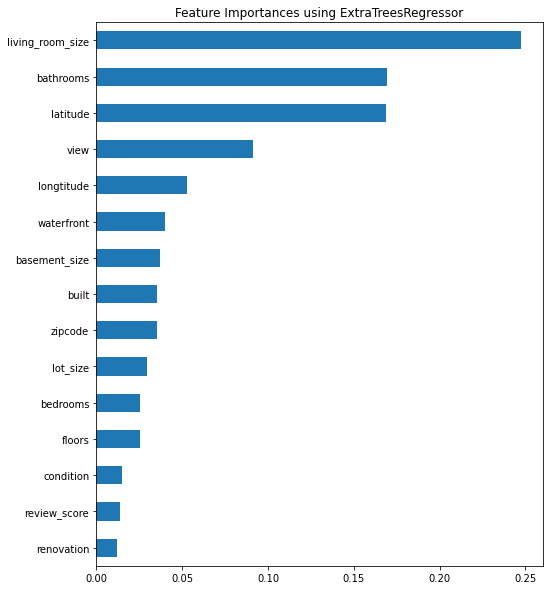

In [16]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor()
etr.fit(trans_df, y)

feat_importances = pandas.Series(etr.feature_importances_, index = trans_df.columns)
sorted_imp = feat_importances.sort_values()
sorted_imp.plot(kind='barh')
plt.title("Feature Importances using ExtraTreesRegressor")
plt.show()

Another model, the <b>ExtraTreesRegressor</b> is used to provide another perspective. The model is fit with the data and the importance of each feature, sorted, is as shown above. The <em>living_room_space</em> is the most importance feature by a small margin, followed by <em>bathrooms</em>, <em>latitude</em> and <em>view</em>. The remaining features have less impact on the price of housing.

##### 3.4 Analysis on the results of the 4 methods

The <b>VarianceThreshold</b> method did not yield any impactful results as the features eliminated has low variance due to reasons as explained above.

The <b>RFE</b> method did not yield any reduction in number of features with the <b>Linear Regression</b> model but removed the <em>floors</em>, <em>condition</em>, <em>review_score</em> and <em>renovation</em> features, resulting in 11 features with the <b>Decision Tree Regressor</b> model.

The <b>Feature selection using LassoCV</b> method highlighted the importance of the <em>living_room_size</em>, <em>zipcode</em>, <em>basement_size</em> and <em>renovation</em> features

The <b>Feature selection using ExtraTreesRegressor</b> method demonstrated the varying importance of the features, with the most important being <em>living_room_size</em>, followed by <em>bathrooms</em> and <em>latitude</em> of the same importance and <em>view</em>

In summary, the <b>RFE</b> with the <b>Decision Tree Regressor</b> model yield results that are in line with the <b>Feature selection using ExtraTreesRegressor</b> method, eliminating the 4 features ranked last in terms of importance. The <em>living_room_size</em> feature is the feature that must be used as demonstrated by the 2 feature selection methods using models.

### Section 4: Summary

In conclusion, the data has been refined and imputed to replace missing values, analyzed to find the correlation between the features and the target, and ran through with feature selection methods to help decide which features to use to ensure maximum accuracy.

The features that will be used are <em>bedrooms</em>, <em>bathrooms</em>, <em>waterfront</em>, <em>view</em>, <em>basement_size</em>, <em>built</em>, <em>zipcode</em>, <em>latitude</em>, <em>longtitude</em>, <em>living_room_size</em>, <em>lot_size</em>, in accordance to the results of the <b>RFE</b> method with the <b>Decision Tree Regressor</b> model and the <b>Feature selection using ExtraTreesRegressor</b> method.